In [6]:
import pandas as pd

## Load datasets
fake = pd.read_csv('/content/fake.csv')
true = pd.read_csv('/content/true.csv')

# add labels for verification during testing
fake['label'] = 0
true['label'] = 1

# combine datasets
data = pd.concat([fake, true]).reset_index(drop=True)

# only use relevant columns
data = data[['title', 'text', 'label']]

# combine title with text to ease processing
data['combined'] = data['title'] + " " + data['text']

# lowercase all text and remove punctuation and common words
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords = set(stopwords.words('english'))
def preprocess_text(text):
    text = text.lower()  # lowercase text
    text = (text.replace("’", "'")
                .replace("‘", "'")
                .replace("“", '"')
                .replace("”", '"'))  # normalize punctuation

    # remove punctuation one char at a time
    for c in text:
        if c in string.punctuation and c != "'":  # keep apostrophes
            text = text.replace(c, " ")

    # collapse multiple spaces
    while "  " in text:
        text = text.replace("  ", " ")

    # remove common words
    tokenized_text = text.split()
    clean = [word for word in tokenized_text if word not in stopwords]
    return " ".join(clean)

# apply preprocessing to data
# FIX 1: use consistent column name 'preprocessed'
data['preprocessed'] = data['combined'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# ============================
# 5-fold stratified CV (each fold: 80% train / 20% test)
# ============================

from sklearn.model_selection import StratifiedKFold

# FIX 2: X should just be the text column (Series), y the labels
X = data['preprocessed']
y = data['label']

# FIX 3: use True (capital T) and pass X, y into split()
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_idx, (train_idx, test_idx) in enumerate(kfolds.split(X, y), start=1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    print(f"Fold {fold_idx}")
    print("  Train size:", len(X_train))
    print("  Test size:", len(X_test))
    print("  Fake % in Train:", y_train.mean())
    print("  Fake % in Test:", y_test.mean())
    print()
    # >>> here is where you'd fit your model on X_train, y_train
    # and evaluate on X_test, y_test


Fold 1
  Train size: 35918
  Test size: 8980
  Fake % in Train: 0.47703101508992707
  Fake % in Test: 0.4769487750556793

Fold 2
  Train size: 35918
  Test size: 8980
  Fake % in Train: 0.47700317389609664
  Fake % in Test: 0.47706013363028954

Fold 3
  Train size: 35918
  Test size: 8980
  Fake % in Train: 0.47700317389609664
  Fake % in Test: 0.47706013363028954

Fold 4
  Train size: 35919
  Test size: 8979
  Fake % in Train: 0.47701773434672456
  Fake % in Test: 0.4770018933066043

Fold 5
  Train size: 35919
  Test size: 8979
  Fake % in Train: 0.47701773434672456
  Fake % in Test: 0.4770018933066043



In [8]:
X_test.head()

,preprocessed
2,sheriff david clarke becomes internet joke thr...
11,watch paul ryan told us care struggling famili...
25,despicable trump suggests female senator would...
32,trump completely screws middle east peace proc...
48,hilarious campaign ad shows voters avoid scand...


In [9]:
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# converts text docs into numerical matrix by assigning a weight to each word
vectorizer = TfidfVectorizer()
X_train_vector = vectorizer.fit_transform(X_train)
X_test_vector = vectorizer.transform(X_test)

#model creation and training
model = LogisticRegression(random_state=42, max_iter=500)
model.fit(X_train_vector, y_train)


# make predictions
y_pred = model.predict(X_test_vector)

print(classification_report(y_test,y_pred))



              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.99      0.99      0.99      4283

    accuracy                           0.99      8979
   macro avg       0.99      0.99      0.99      8979
weighted avg       0.99      0.99      0.99      8979



In [13]:
#https://www.politico.com/news/2025/11/18/trump-admin-deportation-order-00657401
real = "The Trump administration has acknowledged that officials improperly deported a transgender woman to Mexico last week in violation of an immigration judge’s order in March concluding she was likely to face torture in her home country. Now, the administration is working to bring Britania Uriostegui Rios back to the U.S. from Tijuana — perhaps as soon as Tuesday afternoon — while it attempts to find an alternative country for her deportation. Uriostegui Rios is suing to force the administration to release her from custody when she returns to the U.S. Uriostegui Rios, a Nevada resident with a long criminal rap sheet, lost her status as a lawful permanent resident in 2023, after pleading guilty to a felony assault with a deadly weapon. After she received a suspended criminal sentence, Uriostegui was quickly placed in deportation proceedings, and an immigration judge ordered her deported from the country earlier this year. However, the judge also barred the administration from sending Uriostegui Rios to Mexico, finding a likelihood she would be tortured or killed as a result of her transgender status. Despite that order, lawyers for Uriostegui Rios say that on Nov. 11, without warning, she was abruptly transported from Louisiana to Texas and placed on a bus that dropped her off in Mexico. After the attorneys inquired about the deportation, the Justice Department acknowledged the error. “ICE confirmed that your client was removed to Mexico inadvertently,” a DOJ attorney wrote in a Nov. 12 email filed in federal court. The attorney added a day later: “ICE stands ready to remedy the inadvertent removal by allowing your client to voluntarily reenter the United States if your client wishes to do so.” The Department of Homeland Security did not immediately respond to a request for comment. It’s the latest in a string of errors that have at times marred the Trump administration’s mass deportation agenda.The Trump administration sparked national headlines and an ongoing legal battle when it illegally deported a Salvadoran man, Kilmar Abrego Garcia, to his home country despite an immigration judge’s ruling that not be sent there because he could be targeted for gang violence. The administration also worked to facilitate the return of a Guatemalan man who was deported to Mexico without being afforded a chance to lodge fear of persecution there.Uriostegui Rios’ lawyers say the erroneous deportation was likely only discovered because she was one of the few deportees fortunate enough to have lawyers.“The administration says that the immigration courts ultimately are the final arbiters on these issues and decisions. … Yet they still flagrantly violated it,” said Nora Ahmed, legal director for the ACLU of Louisiana, which is representing Uriostegui Rios. “There can be no excuse for that. It’s not an ‘oops.’ How can you ‘oops’ if someone dies?”Uriostegui Rios’ lawyers say their client should be released in part to avoid leaving her in the hands of the same agency that erroneously deported her in the first place. They also say Uriostegui Rios has already spent months in detention without a successful effort to deport her to a safe foreign country, testing the constitutional limits for holding someone while they await deportation. Since March, the administration has attempted, so far without success, to send Uriostegui Rios to Costa Rica, Nicaragua, Honduras and El Salvador."


#https://www.reuters.com/world/us/trump-approval-falls-lowest-his-term-over-prices-epstein-files-reutersipsos-poll-2025-11-18/
reuter = "WASHINGTON, Nov 18 (Reuters) - President Donald Trump's approval rating fell to 38%, the lowest since his return to power, with Americans unhappy about his handling of the high cost of living and the investigation into the late convicted sex offender Jeffrey Epstein, a Reuters/Ipsos poll found.The four-day poll, which concluded on Monday, comes as Trump's grip on his Republican Party shows signs of weakening. The Republican-controlled House of Representatives on Tuesday passed a measure to force the release of Justice Department files on Epstein. Trump had opposed the move for months while one of his closest supporters in Congress, Representative Marjorie Taylor Greene, turned into a harsh critic over his resistance. Trump reversed his position on Sunday as lawmakers prepared to move forward without him. The survey showed Trump's overall approval has fallen two percentage points since a Reuters/Ipsos poll in early November. The poll, which was conducted online, surveyed 1,017 U.S. adults nationwide and had a margin of error of about 3 percentage points. Trump started his second term in office with 47% of Americans giving him a thumbs up. The nine-point decline since January leaves his overall popularity near the lows seen during his first term in office, and close to the weakest ratings for his Democratic predecessor in the White House, Joe Biden. Biden's approval rating sank as low as 35% while Trump's first-term popularity fell as low as 33%. Trump started his second term in office with 47% of Americans giving him a thumbs up. The nine-point decline since January leaves his overall popularity near the lows seen during his first term in office, and close to the weakest ratings for his Democratic predecessor in the White House, Joe Biden. Biden's approval rating sank as low as 35% while Trump's first-term popularity fell as low as 33%. Trump's signature economic policy push has been to hike taxes on imported goods to prop up American manufacturing, but many economists believe the policy has led to higher prices. Expressing frustration over the public perception of his handling of the economy, Trump last week dialed back import taxes on coffee, beef, bananas and other staples. His sagging popularity could make Republicans more vulnerable in next year's congressional elections, though the Reuters/Ipsos poll showed voters continue to see Trump's Republican Party as having a better approach to economic policy.What we're seeing is probably the biggest test of his presidency in terms of his grip on the Republican Party, said Mike Ongstad, an independent strategist and former Republican who has not supported Trumps presidential campaigns.Only 20% of Americans - including just 44% of Republicans - approve of how Trump has handled the Epstein case, the Reuters/Ipsos poll showed. Some 70% of poll respondents - including 87% of Democrats and 60% of Republicans - said they believe the government is hiding information about Epsteins clients."


#without titles and authors#


real = preprocess_text(real)
reuter = preprocess_text(reuter)

real_vec = vectorizer.transform([real])
reuter_vec = vectorizer.transform([reuter])

real_pred = model.predict(real_vec)
reuter_pred = model.predict(reuter_vec)

proba = model.predict_proba(real_vec)
proba2 = model.predict_proba(reuter_vec)


print(f"reuters:{proba2}, Fake/Real\npolitico:{proba} Fake/Real")



reuters:[[0.02690843 0.97309157]], Fake/Real
politico:[[0.55319233 0.44680767]] Fake/Real


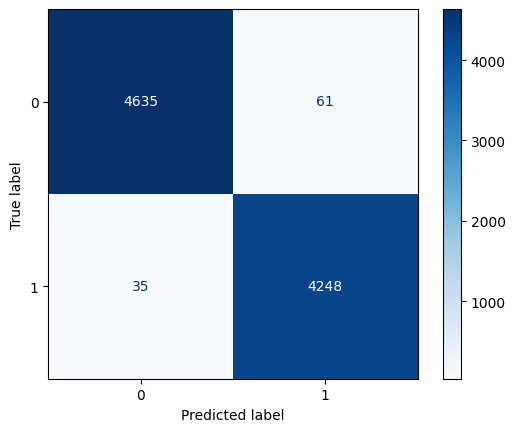

In [14]:
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()